### Generate BBH Injections (SINGLES/ PAIRS) and inject into detectors (H1, L1, V1) 

In [1]:
import pycbc
import numpy as np
import pycbc.types
import pycbc.waveform
import pycbc.detector
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries
from pycbc.waveform.utils import taper_timeseries 
from pycbc.frame import read_frame, write_frame 

In [2]:
duration = 8
minimum_frequency = 20
reference_frequency = 50   # Most sensitive frequency
maximum_frequency = 1024
sampling_frequency = 2048

##### Injection Functions

Preprocessing for integer length duration and adjusting the start and end times

In [3]:

def wf_len_mod_start(wf, extra=1, **prms):
    """
    Taken from GWMAT. Function to modify the starting of a WF so that it starts on an integer GPS time (in sec) + add extra length as specified by the user.

    Parameters
    ----------
    wf :  pycbc.types.TimeSeries
        WF whose length is to be modified.
    extra : int, optional
        Extra length to be added in the beginning after making the WF to start from an integer GPS time (in sec). Default = 1.

    Returns
    -------
    pycbc.types.timeseries.TimeSeries
        Modified waveform starting form an integer time.

    """      

    olen = len(wf)   
    diff = wf.sample_times[0]-np.floor(wf.sample_times[0])  
    #nlen = round(olen+sampling_frequency*(extra+diff))
    dlen = round(sampling_frequency*(extra+diff))
    wf_strain = np.concatenate((np.zeros(dlen), wf))
    t0 = wf.sample_times[0]
    dt = wf.delta_t
    n = dlen
    tnn = t0-(n+1)*dt
    wf_stime = np.concatenate((np.arange(t0-dt,tnn,-dt)[::-1], np.array(wf.sample_times)))
    nwf = pycbc.types.TimeSeries(wf_strain, delta_t=wf.delta_t, epoch=wf_stime[0])
    
    return nwf

def wf_len_mod_end(wf, extra=2, **prms): #post_trig_duration
    """
    Taken from GWMAT. Function to modify the end of a WF so that it ends on an integer GPS time (in sec) + add extra length as specified by the user.

    Parameters
    ----------
    wf : pycbc.types.TimeSeries
        WF whose length is to be modified.
    extra : int, optional
        Extra length to be added towards the end after making the WF to end from an integer GPS time (in sec). 
        Default = 2, which makes sure post-trigger duration is of at least 2 seconds.

    Returns
    -------
    pycbc.types.timeseries.TimeSeries
        Modified waveform ending on an integer time.

    """        

    olen = len(wf)   
    dt = abs(wf.sample_times[-1] - wf.sample_times[-2])
    diff = np.ceil(wf.sample_times[-1]) - (wf.sample_times[-1] + dt)   #wf.sample_times[-1]-int(wf.sample_times[-1])  
    nlen = round(olen + sampling_frequency*(extra+diff))
    wf.resize(nlen)
    
    return wf    

def make_len_power_of_2(wf):
    """
    Taken from GWMAT. Function to modify the length of a waveform so that its duration is a power of 2.

    Parameters
    ----------
    wf : pycbc.types.TimeSeries
        WF whose length is to be modified.
        Modified waveform with duration a power of 2.
    Returns
    -------
    pycbc.types.timeseries.TimeSeries
        Returns the waveform with length a power of 2.

    """    

    dur = wf.duration  
    wf.resize( int(round(wf.sample_rate * np.power(2, np.ceil( np.log2( dur ) ) ))) )
    wf = cyclic_time_shift_of_WF(wf, rwrap = wf.duration - dur )
    
    return wf

def cyclic_time_shift_of_WF(wf, rwrap=0.2):
    """
    Taken from GWMAT. Inspired by PyCBC's function pycbc.types.TimeSeries.cyclic_time_shift(), 
        it shifts the data and timestamps in the time domain by a given number of seconds (rwrap). 
        Difference between this and PyCBCs function is that this function preserves the sample rate of the WFs while cyclically rotating, 
        but the time shift cannot be smaller than the intrinsic sample rate of the data, unlike PyCBc's function.
        To just change the time stamps, do ts.start_time += dt.
        Note that data will be cyclically rotated, so if you shift by 2
        seconds, the final 2 seconds of your data will now be at the
        beginning of the data set.

    Parameters
    ----------
    wf : pycbc.types.TimeSeries
        The waveform for cyclic rotation.
    rwrap : float, optional
        Amount of time to shift the vector. Default = 0.2.

    Returns
    -------
    pycbc.types.TimeSeries
        The time shifted time series.

    """        

    # This function does cyclic time shift of a WF.
    # It is similar to PYCBC's "cyclic_time_shift" except for the fact that it also preserves the Sample Rate of the original WF.
    if rwrap is not None and rwrap != 0:
        sn = abs(int(rwrap/wf.delta_t))     # number of elements to be shifted 
        cycles = int(sn/len(wf))

        cyclic_shifted_wf = wf.copy()

        sn_new = sn - int(cycles * len(wf))

        if rwrap > 0:
            epoch = wf.sample_times[0] - sn_new * wf.delta_t
            if sn_new != 0:
                wf_arr = np.array(wf).copy()
                tmp_wf_p1 = wf_arr[-sn_new:]
                tmp_wf_p2 = wf_arr[:-sn_new] 
                shft_wf_arr = np.concatenate(( tmp_wf_p1, tmp_wf_p2 ))
                cyclic_shifted_wf = pycbc.types.TimeSeries(shft_wf_arr, delta_t = wf.delta_t, epoch = epoch)
        else:
            epoch = wf.sample_times[sn_new]
            if sn_new != 0:
                wf_arr = np.array(wf).copy()
                tmp_wf_p1 = wf_arr[sn_new:] 
                tmp_wf_p2 = wf_arr[:sn_new]
                shft_wf_arr = np.concatenate(( tmp_wf_p1, tmp_wf_p2 ))
                cyclic_shifted_wf = pycbc.types.TimeSeries(shft_wf_arr, delta_t = wf.delta_t, epoch = epoch)  

        for i in range(cycles):        
                epoch = epoch - np.sign(rwrap)*wf.duration
                wf_arr = np.array(cyclic_shifted_wf)[:]
                cyclic_shifted_wf = pycbc.types.TimeSeries(wf_arr, delta_t = wf.delta_t, epoch = epoch)

        assert len(cyclic_shifted_wf) == len(wf), 'Length mismatch: cyclic time shift added extra length to WF.'
        return cyclic_shifted_wf
    else:
        return wf

In [4]:
def inject_singles(mass1, mass2, spin1x, spin1y, spin1z, spin2x, spin2y, spin2z, luminosity_distance, iota, phase, ra, dec, psi, start_time):
    """Generate PyCBC time domain SINGLES waveforms for the injection parameters, and returns injection projections of a signal onto the Hanford, Livingston, Virgo detectors"""

    waveform_params = {
        'approximant': 'IMRPhenomPv2',
        'mass1': mass1,
        'mass2': mass2,
        'spin1x': spin1x,
        'spin1y': spin1y,
        'spin1z': spin1z,
        'spin2x': spin2x,
        'spin2y': spin2y,
        'spin2z': spin2z,
        'distance': luminosity_distance,
        'inclination': iota,
        'coa_phase': phase,
        'f_lower': minimum_frequency,
        'f_ref': reference_frequency,
        'delta_t': 1 / sampling_frequency
    }

    hp, hc = pycbc.waveform.get_td_waveform(**waveform_params)
    hp.start_time += start_time
    hc.start_time += start_time

    det, ifo_signal = dict(), dict()
    for ifo in ['H1', 'L1', 'V1']:
        det[ifo] = pycbc.detector.Detector(ifo)
        ifo_signal[ifo] = det[ifo].project_wave(hp, hc, ra, dec, psi)
        ifo_signal[ifo] = taper_timeseries(ifo_signal[ifo], tapermethod='TAPER_STARTEND', return_lal=False)
        ifo_signal[ifo] = make_len_power_of_2(wf_len_mod_end(wf_len_mod_start(ifo_signal[ifo])))

    ht_H1, ht_L1, ht_V1 = ifo_signal['H1'], ifo_signal['L1'], ifo_signal['V1']

    return ht_H1, ht_L1, ht_V1

In [5]:

def inject_pairs(mass1_a, mass2_a, spin1x_a, spin1y_a, spin1z_a, spin2x_a, spin2y_a, spin2z_a, luminosity_distance_a, iota_a, phase_a, ra_a, dec_a, psi_a, start_time_a, mass1_b, mass2_b, spin1x_b, spin1y_b, spin1z_b, spin2x_b, spin2y_b, spin2z_b, luminosity_distance_b, iota_b, phase_b, ra_b, dec_b, psi_b, start_time_b):
    """Generate PyCBC time domain PAIRS waveforms for the injection parameters, and returns injection projections of a signal onto the Hanford, Livingston, Virgo detectors"""

    waveform_params_a = {
        'approximant': 'IMRPhenomPv2',
        'mass1': mass1_a,
        'mass2': mass2_a,
        'spin1x': spin1x_a,
        'spin1y': spin1y_a,
        'spin1z': spin1z_a,
        'spin2x': spin2x_a,
        'spin2y': spin2y_a,
        'spin2z': spin2z_a,
        'distance': luminosity_distance_a,
        'inclination': iota_a,
        'coa_phase': phase_a,
        'f_lower': minimum_frequency,
        'f_ref': reference_frequency,
        'delta_t': 1 / sampling_frequency
    }

    waveform_params_b = {
        'approximant': 'IMRPhenomPv2',
        'mass1': mass1_b,
        'mass2': mass2_b,
        'spin1x': spin1x_b,
        'spin1y': spin1y_b,
        'spin1z': spin1z_b,
        'spin2x': spin2x_b,
        'spin2y': spin2y_b,
        'spin2z': spin2z_b,
        'distance': luminosity_distance_b,
        'inclination': iota_b,
        'coa_phase': phase_b,
        'f_lower': minimum_frequency,
        'f_ref': reference_frequency,
        'delta_t': 1 / sampling_frequency
    }

    det, ifo_signal_a, ifo_signal_b = dict(), dict(), dict()

    for ifo in ['H1', 'L1', 'V1']:
        det[ifo] = pycbc.detector.Detector(ifo)

        hp_a, hc_a = pycbc.waveform.get_td_waveform(**waveform_params_a)
        hp_a.start_time += start_time_a
        hc_a.start_time += start_time_a

        ifo_signal_a[ifo] = det[ifo].project_wave(hp_a, hc_a, ra_a, dec_a, psi_a)
        ifo_signal_a[ifo] = taper_timeseries(ifo_signal_a[ifo], tapermethod='TAPER_STARTEND', return_lal=False)
        ifo_signal_a[ifo] = make_len_power_of_2(wf_len_mod_end(wf_len_mod_start(ifo_signal_a[ifo])))
        
        hp_b, hc_b = pycbc.waveform.get_td_waveform(**waveform_params_b)
        hp_b.start_time += start_time_b
        hc_b.start_time += start_time_b

        ifo_signal_b[ifo] = det[ifo].project_wave(hp_b, hc_b, ra_b, dec_b, psi_b)
        ifo_signal_b[ifo] = taper_timeseries(ifo_signal_b[ifo], tapermethod='TAPER_STARTEND', return_lal=False)
        ifo_signal_b[ifo] = make_len_power_of_2(wf_len_mod_end(wf_len_mod_start(ifo_signal_b[ifo])))

    ht_H1_a, ht_L1_a, ht_V1_a = ifo_signal_a['H1'], ifo_signal_a['L1'], ifo_signal_a['V1']
    ht_H1_b, ht_L1_b, ht_V1_b = ifo_signal_b['H1'], ifo_signal_b['L1'], ifo_signal_b['V1']

    hf_a_H1, hf_a_L1, hf_a_V1 = ht_H1_a.to_frequencyseries(), ht_L1_a.to_frequencyseries(), ht_V1_a.to_frequencyseries()
    hf_b_H1, hf_b_L1, hf_b_V1 = ht_H1_b.to_frequencyseries(), ht_L1_b.to_frequencyseries(), ht_V1_b.to_frequencyseries()

    hf_H1 = hf_a_H1 + hf_b_H1 * np.exp(-1j * 2 * np.pi * (start_time_b - start_time_a) * hf_b_L1.sample_frequencies)
    hf_L1 = hf_a_L1 + hf_b_L1 * np.exp(-1j * 2 * np.pi * (start_time_b - start_time_a) * hf_b_L1.sample_frequencies)
    hf_V1 = hf_a_V1 + hf_b_V1 * np.exp(-1j * 2 * np.pi * (start_time_b - start_time_a) * hf_b_V1.sample_frequencies)

    ht_H1, ht_L1, ht_V1 = hf_H1.to_timeseries(), hf_L1.to_timeseries(), hf_V1.to_timeseries()
    
    return ht_H1, ht_L1, ht_V1

##### Generating waveforms

In [6]:
# Generating SINGLES A & B

ht_a_H1, ht_a_L1, ht_a_V1 = inject_singles(mass1=30, mass2=40, spin1x=0, spin1y=0, spin1z=0.5, spin2x=0, spin2y=0, spin2z=0.5, luminosity_distance=500, iota=2.5, phase=0, ra=2.2, dec=-1.25, psi=1.75, start_time=1126259462.4116447)

ht_b_H1, ht_b_L1, ht_b_V1 = inject_singles(mass1=20, mass2=30, spin1x=0, spin1y=0, spin1z=0.75, spin2x=0, spin2y=0, spin2z=0.25, luminosity_distance=800, iota=1.5, phase=2, ra=1.2, dec=1.25, psi=2.75, start_time=1126259462.4116447+0.1)

# Generating PAIRS

ht_H1, ht_L1, ht_V1 = inject_pairs(mass1_a=30, mass2_a=40, spin1x_a=0, spin1y_a=0, spin1z_a=0.5, spin2x_a=0, spin2y_a=0, spin2z_a=0.5, luminosity_distance_a=500, iota_a=2.5, phase_a=0, ra_a=2.2, dec_a=-1.25, psi_a=1.75, start_time_a=1126259462.4116447, mass1_b=20, mass2_b=30, spin1x_b=0, spin1y_b=0, spin1z_b=0.75, spin2x_b=0, spin2y_b=0, spin2z_b=0.25, luminosity_distance_b=450, iota_b=1.5, phase_b=2, ra_b=1.2, dec_b=1.25, psi_b=2.75, start_time_b=1126259462.4116447+0.1)

Reading the PyCBC frame files through GwPy

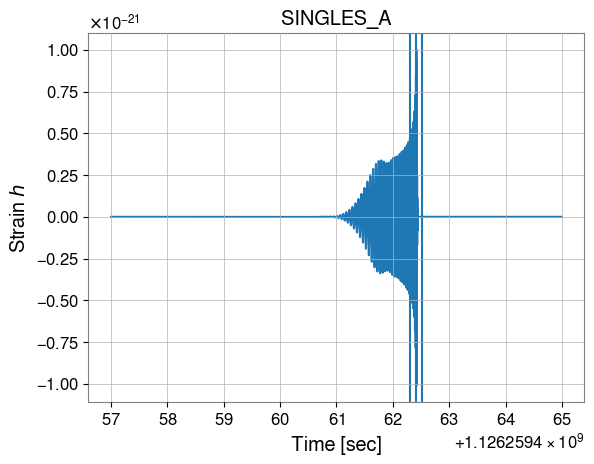

In [7]:
h_a_H1_gwpy = TimeSeries.read(source='../../output/injections/sarathi/SINGLES_A_H1.gwf', channel='H1:PyCBC_Injection', format='gwf.lalframe', ).astype(dtype='float64', subok=True, copy=False,)
plt.plot(h_a_H1_gwpy)
plt.title('SINGLES_A')
plt.ylabel('Strain $h$')
plt.xlabel('Time [sec]')
plt.axvline(1126259462.4116447)
plt.axvline(1126259462.4116447+0.1)
plt.axvline(1126259462.4116447-0.1)
plt.show()

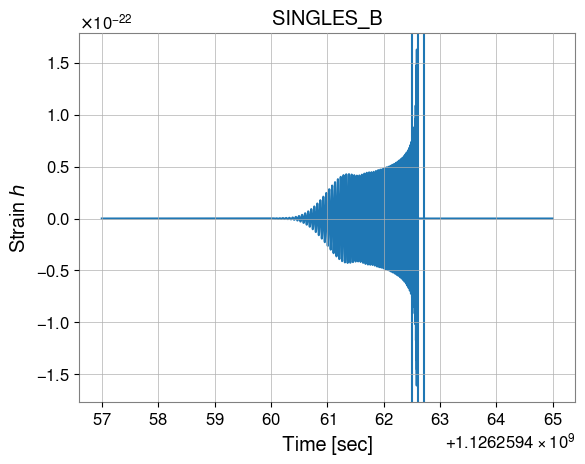

In [10]:
h_b_H1_gwpy = TimeSeries.read(source='../../output/injections/sarathi/SINGLES_B_H1.gwf', channel='H1:PyCBC_Injection', format='gwf.lalframe', ).astype(dtype='float64', subok=True, copy=False,)
plt.plot(h_b_H1_gwpy)
plt.title('SINGLES_B')
plt.ylabel('Strain $h$')
plt.xlabel('Time [sec]')
plt.axvline(1126259462.4116447+0.2)
plt.axvline(1126259462.4116447+0.2+0.1)
plt.axvline(1126259462.4116447+0.2-0.1)
plt.show()

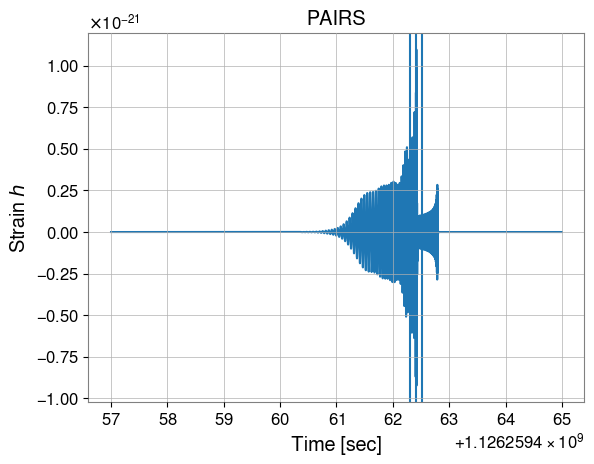

In [9]:
h_H1_gwpy = TimeSeries.read(source='../../output/injections/sarathi/PAIRS_H1.gwf', channel='H1:PyCBC_Injection', format='gwf.lalframe', ).astype(dtype='float64', subok=True, copy=False,)
plt.plot(h_H1_gwpy)
plt.title('PAIRS')
plt.ylabel('Strain $h$')
plt.xlabel('Time [sec]')
plt.axvline(1126259462.4116447)
plt.axvline(1126259462.4116447+0.1)
plt.axvline(1126259462.4116447-0.1)
plt.show()